# CALC DISTANCE METHODS

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import fiona as fio
from haversine import haversine, Unit
from pyproj import CRS
import utm

In [2]:
def utm_crs_from_latlon(lat, lon):
    crs_params = dict(
        proj = 'utm',
        zone = utm.latlon_to_zone_number(lat, lon),
        south = lat < 0
        )
    return CRS.from_dict(crs_params)

In [3]:
fdata = gpd.read_file('../test_data/airport.geojson', engine='fiona')
fdata.set_crs(4326, inplace=True)
xs, ys = fdata["geometry"][0].exterior.coords.xy # (x: lon, y: lat)

# length in JOSM - file square.gml
print(f'Correct length in JOSM\t{15591}')

# length in haversine
haversine_len = 0
for i in range(1,len(xs)):
    p0 = (ys[i-1], xs[i-1])
    p1 = (ys[i], xs[i])
    haversine_len += haversine(p0, p1, unit=Unit.METERS) # (lat, lon)
print(f'Length in Haversine\t{haversine_len}')

# length in utm
centroid = fdata["geometry"][0].centroid
utm_crs = utm_crs_from_latlon(lat = centroid.y,
                                lon = centroid.x)
print(f'Length in UTM CRS\t{fdata.to_crs(utm_crs).length[0]}')

# length in 3857
print(f'Length in CRS:3857\t{fdata.to_crs(3857).length[0]}')

Correct length in JOSM	15591
Length in Haversine	15573.724398426486
Length in UTM CRS	15551.849684898425
Length in CRS:3857	15873.208167118197


# WRITE FILE

In [116]:
# import osmnx as ox
# import folium
# gdf_airport = ox.geocode_to_gdf('W54242195', by_osmid=True) # san bay tan son nhat
# gdf_stadium = ox.geocode_to_gdf('W750361871', by_osmid=True) # san van dong quan khu 7

# columns = ['geometry']
# gdf_airport = gdf_airport[columns]
# gdf_stadium = gdf_stadium[columns]

# gdf_districts = gpd.read_file('C:/Users/Huynh Tan Thanh/Downloads/Vietnam_Demographic_Data_(Huyen)_S.geojson')
# district_cols = ["OBJECTID", "geometry", "NAME_2"]
# gdf_districts = gdf_districts[district_cols]
# district_ids = [266,279]
# gdf_districts = gdf_districts[gdf_districts["OBJECTID"].isin(district_ids)]
# gdf_districts.reset_index(inplace=True,drop=True)

# # write file
# gdf_airport.to_file('../test_data/airport.geojson', driver='GeoJSON')
# gdf_stadium.to_file('../test_data/stadium.geojson', driver='GeoJSON')
# gdf_districts.to_file('../test_data/districts.geojson', driver='GeoJSON')

# Load data & Implement overlay operators

In [6]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

gdf_airport = gpd.read_file('../test_data/airport.geojson')
gdf_stadium = gpd.read_file('../test_data/stadium.geojson')
gdf_districts = gpd.read_file('../test_data/districts.geojson')
gdf_river = gpd.read_file('../test_data/Amazon_river.geojson')

## Overlay operators:
![overlay operators](../test_data/overlay_operations.png)
- Intersection
- Union
- Difference
- Symetrical Difference
## Others:
- Centroids
- Convex Hull
- Simplify

### 1. Intersection

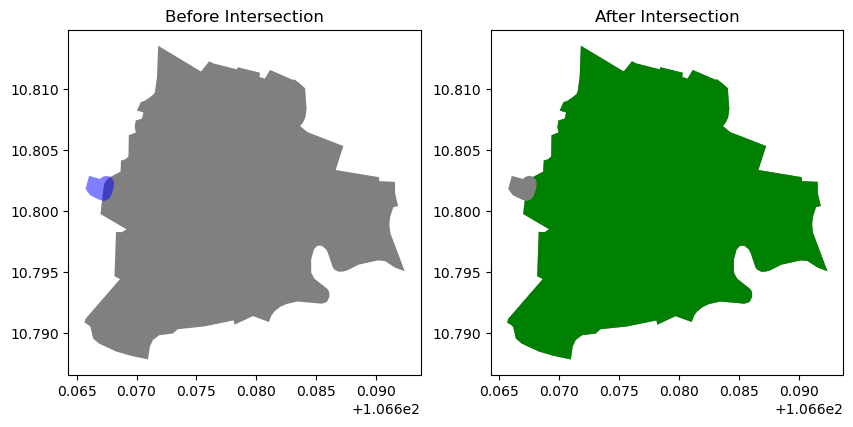

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Prepare data
gdf_1 = gdf_districts[:1]
gdf_2 = gdf_stadium

# Plot before
ax = gdf_1.plot(ax= axs[0],color='gray')
gdf_2.plot(ax=axs[0], color='blue', alpha=0.5)
ax.set_title('Before Intersection')
# Plot after
gdf_intersect = gdf_1.overlay(gdf_2, how='difference')
if not gdf_intersect.empty:
    ax = gdf_1.plot(ax=axs[1],color='gray')
    gdf_2.plot(ax=ax, color='gray')

    gdf_intersect.plot(ax=ax, color='green')
    ax.set_title('After Intersection')
else:
    axs[1].set_title('Empty overlay')

### Centroids

POINT (106.66698987616819 10.801924643366325)


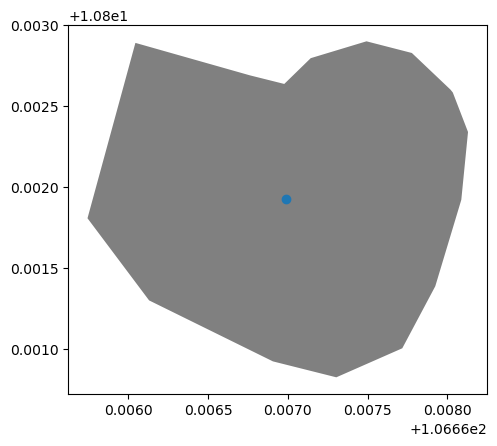

In [29]:
gdf = gdf_stadium
centroid = gdf["geometry"][0].centroid
print(centroid)

# Plot
ax = gdf.plot(color='gray')
ax.scatter(centroid.xy[0], centroid.xy[1])

### Simplify

<Axes: >

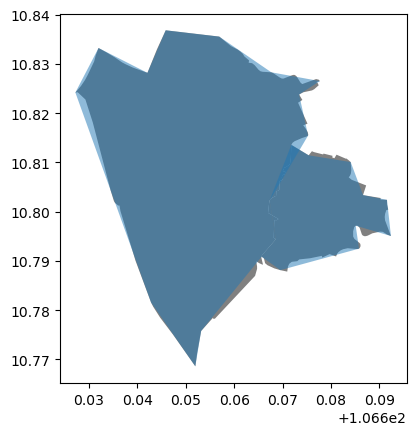

In [39]:
gdf = gdf_districts
# Generalize geometry
gdf_simplify = gdf.simplify(tolerance=90/43200)

# Plot
ax = gdf.plot(color='gray')
gdf_simplify.plot(ax=ax, alpha=0.5)

### Convex Hull

<Axes: >

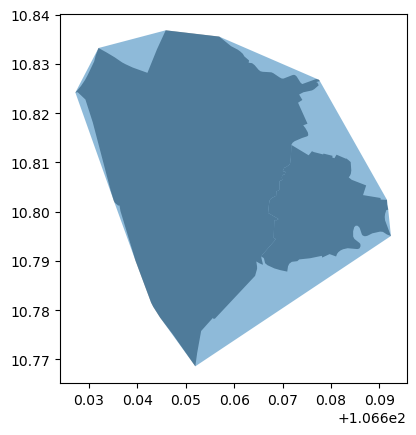

In [18]:
gdf = gdf_districts
convex_hull = gdf.unary_union.convex_hull
gdf_convex_hull = gdf[:1].copy()
gdf_convex_hull.geometry = [convex_hull]
#plot
ax = gdf.plot(color='gray')
gdf_convex_hull.plot(ax=ax, alpha=0.5)

In [60]:
# import folium
# map = folium.Map(location=[10.817778935719275, 106.65619538171518],
#                     tiles="Cartodb dark_matter", zoom_start=13)
# map

# CONVERT GEOJSON TO GML

In [40]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
gdf_airport = gpd.read_file('../test_data/airport.geojson')

from pygml.v32 import encode_v32
from lxml import etree
tree = encode_v32(gdf_airport.__geo_interface__['features'][0]['geometry'], 'ID')
print(etree.tostring(tree, pretty_print=True).decode())

<gml:Polygon xmlns:gml="http://www.opengis.net/gml/3.2" srsName="urn:ogc:def:crs:OGC::CRS84" gml:id="ID">
  <gml:exterior>
    <gml:LinearRing>
      <gml:posList>106.6332163 10.8137323 106.6332203 10.8136237 106.6332377 10.8135189 106.6343516 10.8100508 106.6346703 10.8098511 106.6347368 10.8096114 106.6345914 10.8092631 106.6345401 10.809072 106.6345036 10.8089556 106.6345344 10.8088694 106.634707 10.8086273 106.635418 10.8074519 106.6355602 10.8072326 106.6358773 10.806754 106.6361463 10.80641 106.6362732 10.8062804 106.6365726 10.8064225 106.6381383 10.8070905 106.6397445 10.8077585 106.6399069 10.8078706 106.6401722 10.8080441 106.6407399 10.8085045 106.6411581 10.8093574 106.6412826 10.8096145 106.6414199 10.8097807 106.641605 10.8098999 106.6418828 10.8100034 106.6424154 10.8102231 106.6437247 10.8106843 106.6458536 10.8113669 106.6463742 10.8107852 106.6463162 10.8093994 106.6481495 10.8091001 106.6482407 10.809432 106.6482783 10.8104112 106.6503596 10.8109022 106.6506708 10.81